# BAYESIAN AB TESTING

In [17]:
import warnings
warnings.filterwarnings("ignore")

import math
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn
%matplotlib inline

In [18]:
from ipywidgets import widgets
from IPython.display import display
from IPython.display import clear_output

In [468]:
def lbeta(a,b):
    return math.lgamma(a) + math.lgamma(b) - math.lgamma(a+b)

def prob_b_beats_a(alpha_a, beta_a, alpha_b, beta_b):
    total = 0.
    for i in range(int(round(alpha_b))):
        total += math.exp(lbeta(alpha_a+i,beta_a+beta_b)
                          - math.log(beta_b+i)
                          - lbeta(i+1,beta_b)
                          - lbeta(alpha_a,beta_a))
    return total

def prob_b_beats_a_approx(alpha_a,beta_a,alpha_b,beta_b):
    alpha_a,alpha_b,beta_a,beta_b = float(alpha_a),float(alpha_b),float(beta_a),float(beta_b)
    u_a = alpha_a / (alpha_a + beta_a)
    u_b = alpha_b / (alpha_b + beta_b)
    var_a = alpha_a * beta_a / ((alpha_a + beta_a)**2 * (alpha_a + beta_a + 1))
    var_b = alpha_b * beta_b / ((alpha_b + beta_b)**2 * (alpha_b + beta_b + 1))
    return 1-scipy.stats.norm(u_b - u_a, math.sqrt(var_a + var_b)).cdf(0)
    

def beta_distr(p,n,k):
    assert n>=k, "n must be greater or equal than k"
    if k==0 and n==0:
            return 1.
    if p==0:
        if k>0:
            return 0.
        else:
            return np.nan
    if p==1:
        if n-k>0:
            return 0.
        else:
            return np.nan
    return math.exp(k*math.log(p) + (n-k)*math.log(1-p) - lbeta(k+1,n-k+1))

def alpha_beta_from_moments(m,v):
    alpha = ((1-m)/v - 1/m)*m**2
    beta = alpha*(1/m - 1)
    return alpha,beta

def moments_from_alpha_beta(alpha,beta):
    alpha,beta=float(alpha),float(beta)
    mean = alpha/(alpha+beta)
    var = alpha*beta/((alpha+beta)**2*(alpha+beta+1))
    return mean,var


def joint_beta_distr(n1,k1,n2,k2):
    def inner(x,y):
        return beta_distr(x,n1,k1)*beta_distr(y,n2,k2)
    return inner

In [530]:
def plot_beta_distr(s,impr_a,clicks_a,color='red',label='A',mean=None):

    beta_distr_v = np.vectorize(lambda x: beta_distr(x,impr_a,clicks_a))
    x = np.linspace(0,1,1000)
    y = beta_distr_v(x)
    s.plot(x,y,color=color,label=label)
    
    s.axes.xaxis.set_label_text('CTR')
    s.axes.yaxis.set_label_text('Probability Density')
    
    if mean is not None:
        s.vlines(mean,0,y.max(),color=color,linestyle='dashed')
        text = s.text(mean,0,'mean',horizontalalignment='right',verticalalignment='bottom',fontsize=12,rotation=90,color=color)


def plot_dual_distr(s,impr_a,clicks_a,impr_b,clicks_b):
    
    plot_beta_distr(s,impr_a,clicks_a)  
    plot_beta_distr(s,impr_b,clicks_b,color='blue',label='B')
    s.legend()

def plot_joint_distr(s,impr_a,clicks_a,impr_b,clicks_b):
    
    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)

    fun = joint_beta_distr(impr_a,clicks_a,impr_b,clicks_b)

    # filling the heatmap, value by value
    fun_map = np.empty((x.size, y.size))
    for i in range(x.size):
        for j in range(y.size):
            fun_map[i,j] = fun(x[i], y[j])
            
    s.grid(False)
    im = s.imshow(
        fun_map,
        extent=(0, 1, 0, 1),
        origin='lower',
        cmap=cmap.Spectral_r)
    
    s.plot([0,1],[0,1])

def plot_result(impressions_a,clicks_a,impressions_b,clicks_b):
    
    alpha_a = clicks_a + 1
    beta_a = impressions_a - clicks_a + 1
    alpha_b = clicks_b + 1
    beta_b = impressions_b - clicks_b + 1
    
    fig = plt.figure(figsize=(20,6))
    s1 = fig.add_subplot(1, 2, 1, title='Empirical Distributions for A and B') 
    plot_dual_distr(s1, impressions_a, clicks_a, impressions_b, clicks_b)

    s2 = fig.add_subplot(1, 2, 2, title='Joint Distribution', xlabel='CTR B', ylabel='CTR A')
    plot_joint_distr(s2,impressions_a,clicks_a,impressions_b,clicks_b)

    plt.tight_layout()
    plt.show()
    
    print "There is a {:.0f}% chance that B beats A".format(prob_b_beats_a(alpha_a,beta_a,alpha_b,beta_b)*100)

def plot_prior(impr_a,clicks_a,mean_a):

    fig = plt.figure(figsize=(20,2))
    s1 = fig.add_subplot(1, 1, 1, title='Empirical Distribution of Prior Knowledge') 
    plot_beta_distr(s1, impr_a, clicks_a, mean=mean_a)
    
    plt.show()
    

def plot_all(mean_a,std_a,impr_a,clicks_a,impr_b,clicks_b):
    
    mean_a /= 100.
    var_a = std_a/100.*mean_a*(1-mean_a)/3
    
    alpha_a,beta_a = alpha_beta_from_moments(mean_a,var_a)
    
    clicks_a_prior = max(0.,alpha_a - 1)
    impr_a_prior = max(0.,beta_a + clicks_a_prior - 1)
    
    plot_prior(impr_a_prior,clicks_a_prior,mean_a)
    plot_result(
        impr_a+impr_a_prior,
        clicks_a+clicks_a_prior,
        impr_b+impr_a_prior,
        clicks_b+clicks_a_prior)

In [531]:
slider_mean_a = widgets.FloatSlider(10,description='Prior CTR',min=0,max=100,width='100%',continuous_update=False)
slider_std_a = widgets.FloatSlider(10,description='Prior STD',min=0,max=100,width='100%',continuous_update=False)

text_impr_a = widgets.IntText(1000,description='Imprs A')
text_clicks_a = widgets.IntText(100,description='Clicks A')
text_impr_b = widgets.IntText(100,description='Imprs B')
text_clicks_b = widgets.IntText(15,description='Clicks B')

def toggle_no_prior(cb):
    if cb['owner'].value:
        slider_mean_a.value = 50
        slider_std_a.value = 100
        slider_mean_a.disabled = True
        slider_std_a.disabled = True
    else:
        slider_mean_a.disabled = False
        slider_std_a.disabled = False

checkbox_no_prior = widgets.Checkbox(False,description='No Prior')
checkbox_no_prior.observe(toggle_no_prior,'value')

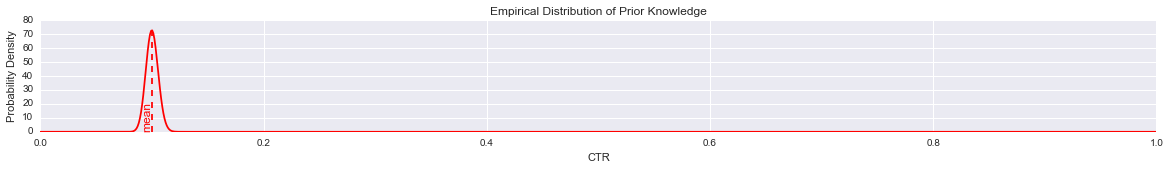

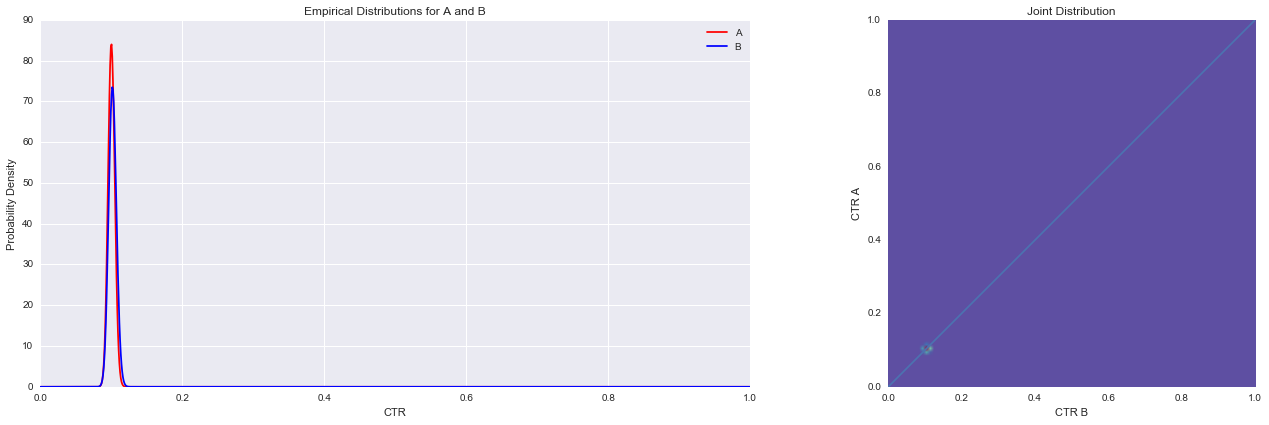

There is a 59% chance that B beats A


In [532]:
w=widgets.interactive(
    plot_all,
    mean_a=slider_mean_a,
    std_a=slider_std_a,
    impr_a=text_impr_a,
    clicks_a=text_clicks_a,
    impr_b=text_impr_b,
    clicks_b=text_clicks_b)
display(w)
display(checkbox_no_prior)

## References

https://web.archive.org/web/20150419163005/http://www.bayesianwitch.com/blog/2014/bayesian_ab_test.html

http://www.evanmiller.org/bayesian-ab-testing.html

In [248]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')